# Model Report

In this notebook you'll find a report on how we built a model for predicting one year of electrical consumption based on our dataset

Let's start by looking at the data again, to refresh our memories

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
power_load_df = pd.read_csv("../datasets/italian-power-load/load.csv")

<AxesSubplot:xlabel='Date'>

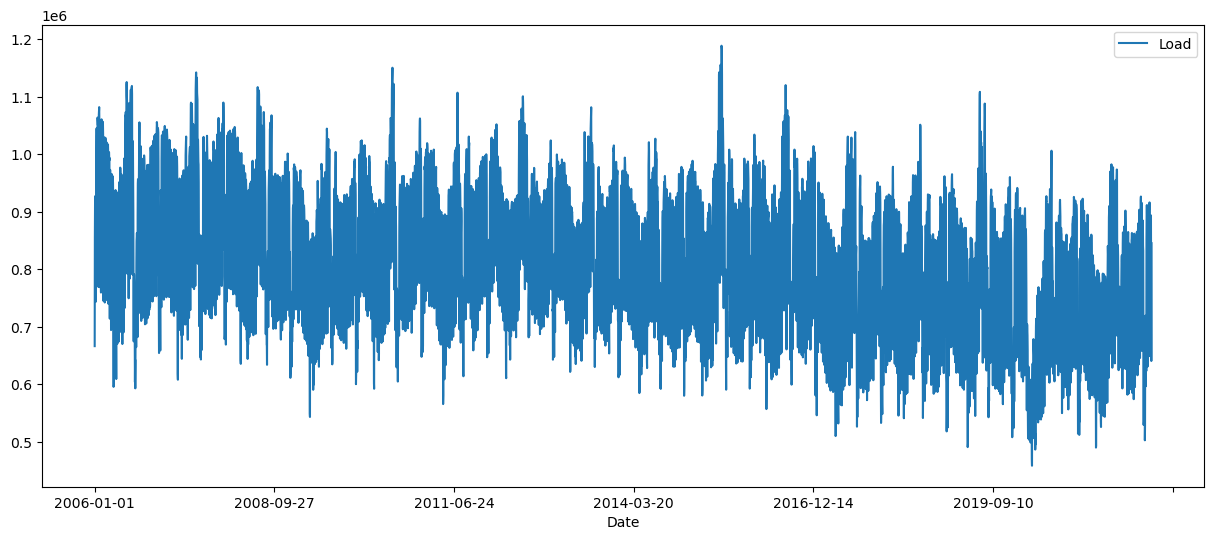

In [3]:
power_load_df.plot(x='Date',y='Load',kind='line',figsize=(15,6))

Thats our series! Now, we know we have repeating patterns by week, and within the year, we'll likely have to take that into account when creating our model. Some models need us to be more explicit with that kind of stuff, than others.  
Also, we learned from our previous analysis that we have special dates of interest that cause some of the behaviour in our series, and we also know that 2020 is an odd year, and we were told we can use 2019 as a testing year, and use the rest (2006-2018) to let the model learn how it behaves before attempting to predict anything.

The first thing we usually do when training models is to define what our metrics will be, how are we going to evaluate the results? Without that, we won't be able to compare models and say which is best, or to have a precise number telling us "your model is THIS good (or bad)"  
There are many measures we can use, they vary on the type of data and situation.  
We could look at a few with our stakeholders, and see if there is something they'd like us to consider when choosing one (like for example, if it is much worse for them to **under**estimate a value than to **over**estimate it, in such case we'd have to find asymetrical measures that take that into account) but since we have none here to give voice to those considerations, we'll choose a common one.  
  
In this case we'll use **MAPE**, which stands for Mean Absolute Percentage Error, which means that for each forecast, we'll see how far it is from the truth (that's the error), and we'll make an average of all errors, making sure that underestimations don't compensate overestimations by using the absolute values. We'll then express that error as a percentage of the real value, that way, we don't need to remember the scale of our data and it gives us a nice sense of how bad the error was (it isn't the same to say "we missed by 0.4MWh" not knowing if thats a lot or not, than saying "we missed the mark by 4%").
So as I'm sure you've guessed, with MAPE, the smaller the value we get, the better.  
  
We'll also use a second measure, **R Squared**, that gives us a sense of how nice (or badly) our entire prediction series fits the real series. We'll mainly use it to compare models, and with this one, the closer we get to 1, the better.

Now that that's decided, the second thing we need to do is **establish a baseline**. What does that mean? Well, we need to find a "dumb" model, or "simple" model that we can train quickly and works on fairly simple premises. For example, **the mean**, what if we take the mean consumption of the whole previous year, and thats our prediction for next year? It will have errors, sure, but it gives us an general idea on the order of magnitude of the electrical consumption, right? That would be a baseline, using it we'll know what kind of errors we get from such simple model and when we start developing better ones, we'll know how much we've improved and how far we've come!  
In this case, I'll use a better model than the mean, one called TBATS, that can be good for seasonal time series, but we'll train it giving it the bare minimum information, we'll then go over to more complex models and we'll enrich our dataset to try and help the model out.

In [4]:
from darts import TimeSeries

power_load_df.Date = pd.to_datetime(power_load_df.Date)
power_load_df.set_index('Date',inplace=True)

#We'll only use two years since we are messing around with models, no need to train with everything just yet, it'll be faster
power_series = TimeSeries.from_dataframe(power_load_df[:'2019-12-31'])
train, val = power_series.split_before(pd.Timestamp('20190101'))

In [9]:
from model_trainer import ModelTrainer
trainer = ModelTrainer()
trainer.fit_baseline(train_ts=train)

In [13]:
trainer.predict_baseline(prediction_length=len(val))
baseline_mape, baseline_r2 = trainer.evaluate_forecast(val_ts=val, model_type='baseline')
print("TBATS obtained MAPE: {:.2f} and r2: {:.2f}".format(baseline_mape, baseline_r2))

TBATS obtained MAPE: 7.78 and r2: 0.51


<AxesSubplot:xlabel='Date'>

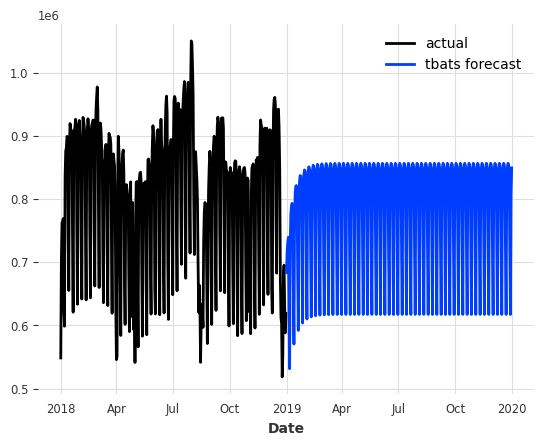

In [14]:
power_series.slice(pd.Timestamp('20180101'),pd.Timestamp('20181231')).plot(label="actual")
model_trainer.baseline_forecast.plot(label="tbats forecast")

<AxesSubplot:xlabel='Date'>

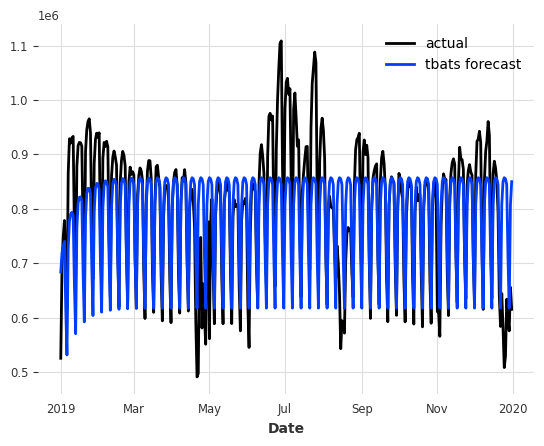

In [15]:
val.plot(label="actual")
model_trainer.baseline_forecast.plot(label="tbats forecast")

Okey, so we got a MAPE of 7.78% (which I think is pretty good actually, it would mean that in general our predictions are ±8% of the actual value), and a R2 of 0.51. This is what we have to beat!  
Yoy may also notice that the model is a bit rudimentary, it didn't capture the ups and downs of the seasons, or the holidays. But it did capture the weekly behaviour and that's why it predicted the way it did.

Now we'll enrich our dataset and switch to a more complex model that might capture better the details of the series.  
   
- First we'll add all details that we already have in the data, but we'll make it explicit so the model pays extra attention, like the year, month, day, quarter, etc.  
- We will also add all Italian holidays, and we'll make special time series for our holidays of interest that we noted in our analysis in challenge one, like Ferragosto, Natale, etc.  
- Something else we can do, is separate the overall trend, the weekly seasonality, and the yearly seasonality. We have the option of feeding them to the model as another feature, or removing it from the timeseries, to later be added after forecasting.
- We will also scale our data, since we will be using neural networks and they work better with values between 0 and 1 instead of high values like we have here
- Another thing we can do, is take advantage of our model's ability to work with past and future data. For example, we know the important holidays will be the same each year, so why not add it as information that they are coming in the future as well? The model can handle and use such information, not like others that only look at the past.

I'll do everything behind the scenes so we don't use up space with all the code nonesense

In [16]:
from data_enricher import DataEnricher
enricher = DataEnricher(power_load_df)

In [17]:
y_scaler, y_train_scaled, y_val, covariates_scaled = enricher.enrich_dataset()

In [18]:
covariates_scaled.components

Index(['is_weekend', 'month', 'week', 'day', 'year', 'dayofyear', 'dayofweek',
       'quarter', 'holiday', 'capodanno', 'epifania', 'liberazione', 'lavoro',
       'repubblica', 'ferragosto', 'santi', 'concezione', 'natale', 'trend',
       'seasonal_year'],
      dtype='object', name='component')

In [19]:
trainer.fit_model(y_train_scaled,covariates_scaled)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 23.4 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 11.6 K
6  | static_context_grn                | _GatedResidualNetwork            | 648   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 648   
8  | static_cont

Epoch 9: 100%|██████████| 126/126 [03:42<00:00,  0.57it/s, train_loss=0.191]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 126/126 [03:42<00:00,  0.57it/s, train_loss=0.191]


In [20]:
trainer.predict_model(prediction_length=len(y_val), covariates_scaled=covariates_scaled, y_scaler=y_scaler)
model_mape, model_r2 = trainer.evaluate_forecast(val_ts=y_val, model_type='improved')
print("TFT obtained MAPE: {:.2f} and r2: {:.2f}".format(model_mape, model_r2))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
TFT obtained MAPE: 6.30 and r2: 0.59


<AxesSubplot:xlabel='Date'>

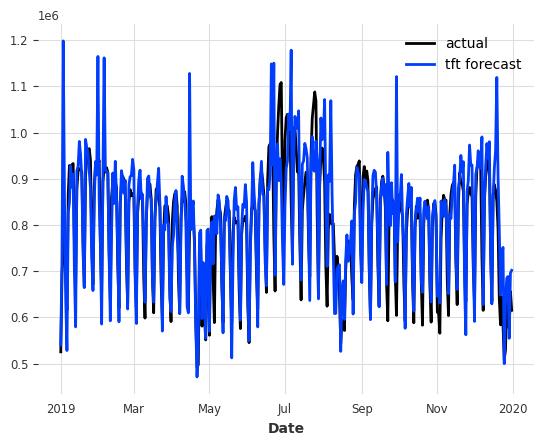

In [21]:
y_val.plot(label="actual")
trainer.improved_forecast.plot(label="tft forecast")

That does look better doesn't it?!
And our metrics say so too! MAPE is 6.3% vs 7.78%, and R2 is 0.59 vs 0.51.  
Let's zoom in and look at some months to see it in action

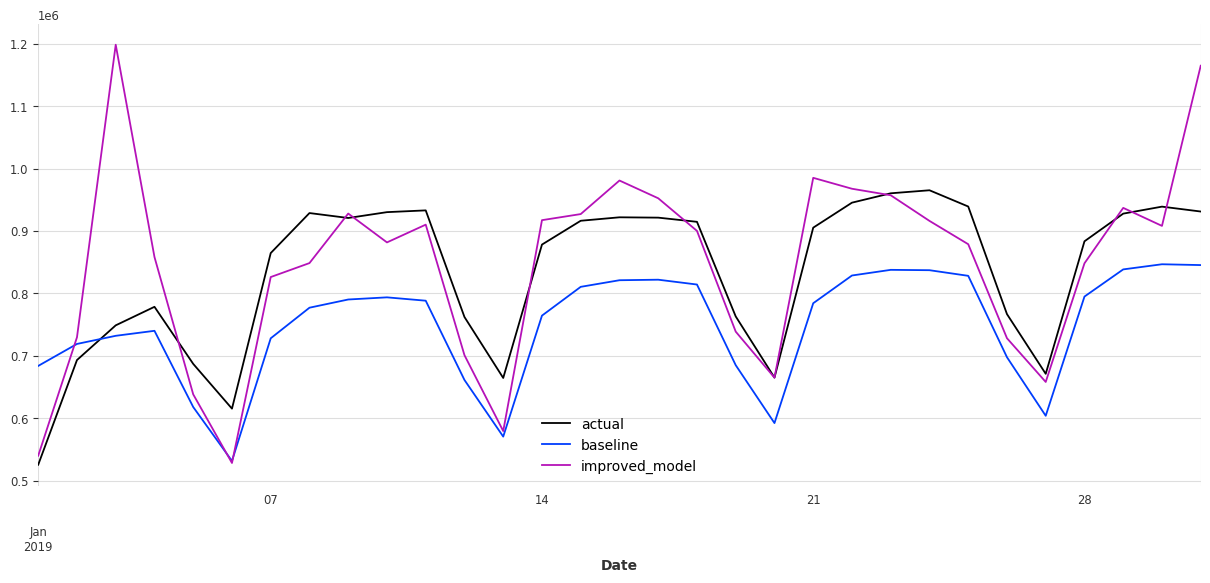

In [24]:
trainer.compare_month(1,val_ts=y_val)

we can see that the improved model stays generally closer to the ground truth, however we seem to have some outliers that need to be handled, at the start of the month it greatly overestimated, as well as at the end

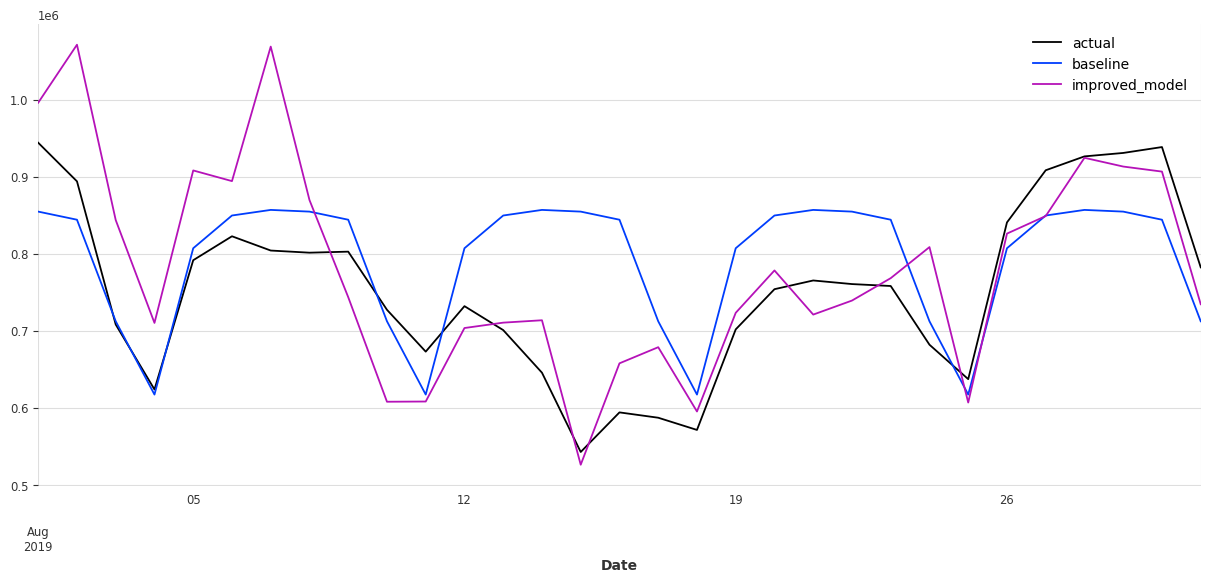

In [25]:
trainer.compare_month(8,val_ts=y_val)

Here in August we can see that our new model follows much better the valley of Ferragosto, while the baseline just repeats the same pattern all throughout. And we again see some overestimations, but it is still better than the baseline. So, **SUCCESS!**